<a href="https://colab.research.google.com/github/aseiple/ocr-testing-results/blob/main/OCRResults.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run only once

In [ ]:
!git clone https://github.com/aseiple/ocr-testing-results

import matplotlib.pyplot as plt
import cv2
import json

- Ignore Frametime and FPS for image 0. OCR engines seem to take a frame to warm up.
- ML Kit doesn't report confidence so always marked as 1
- PaddleOCR set to cutoff anything below 0.5 confidence, this can be changed if not enough is being picked up

(0.0, 1.0, 0.0, 1.0)

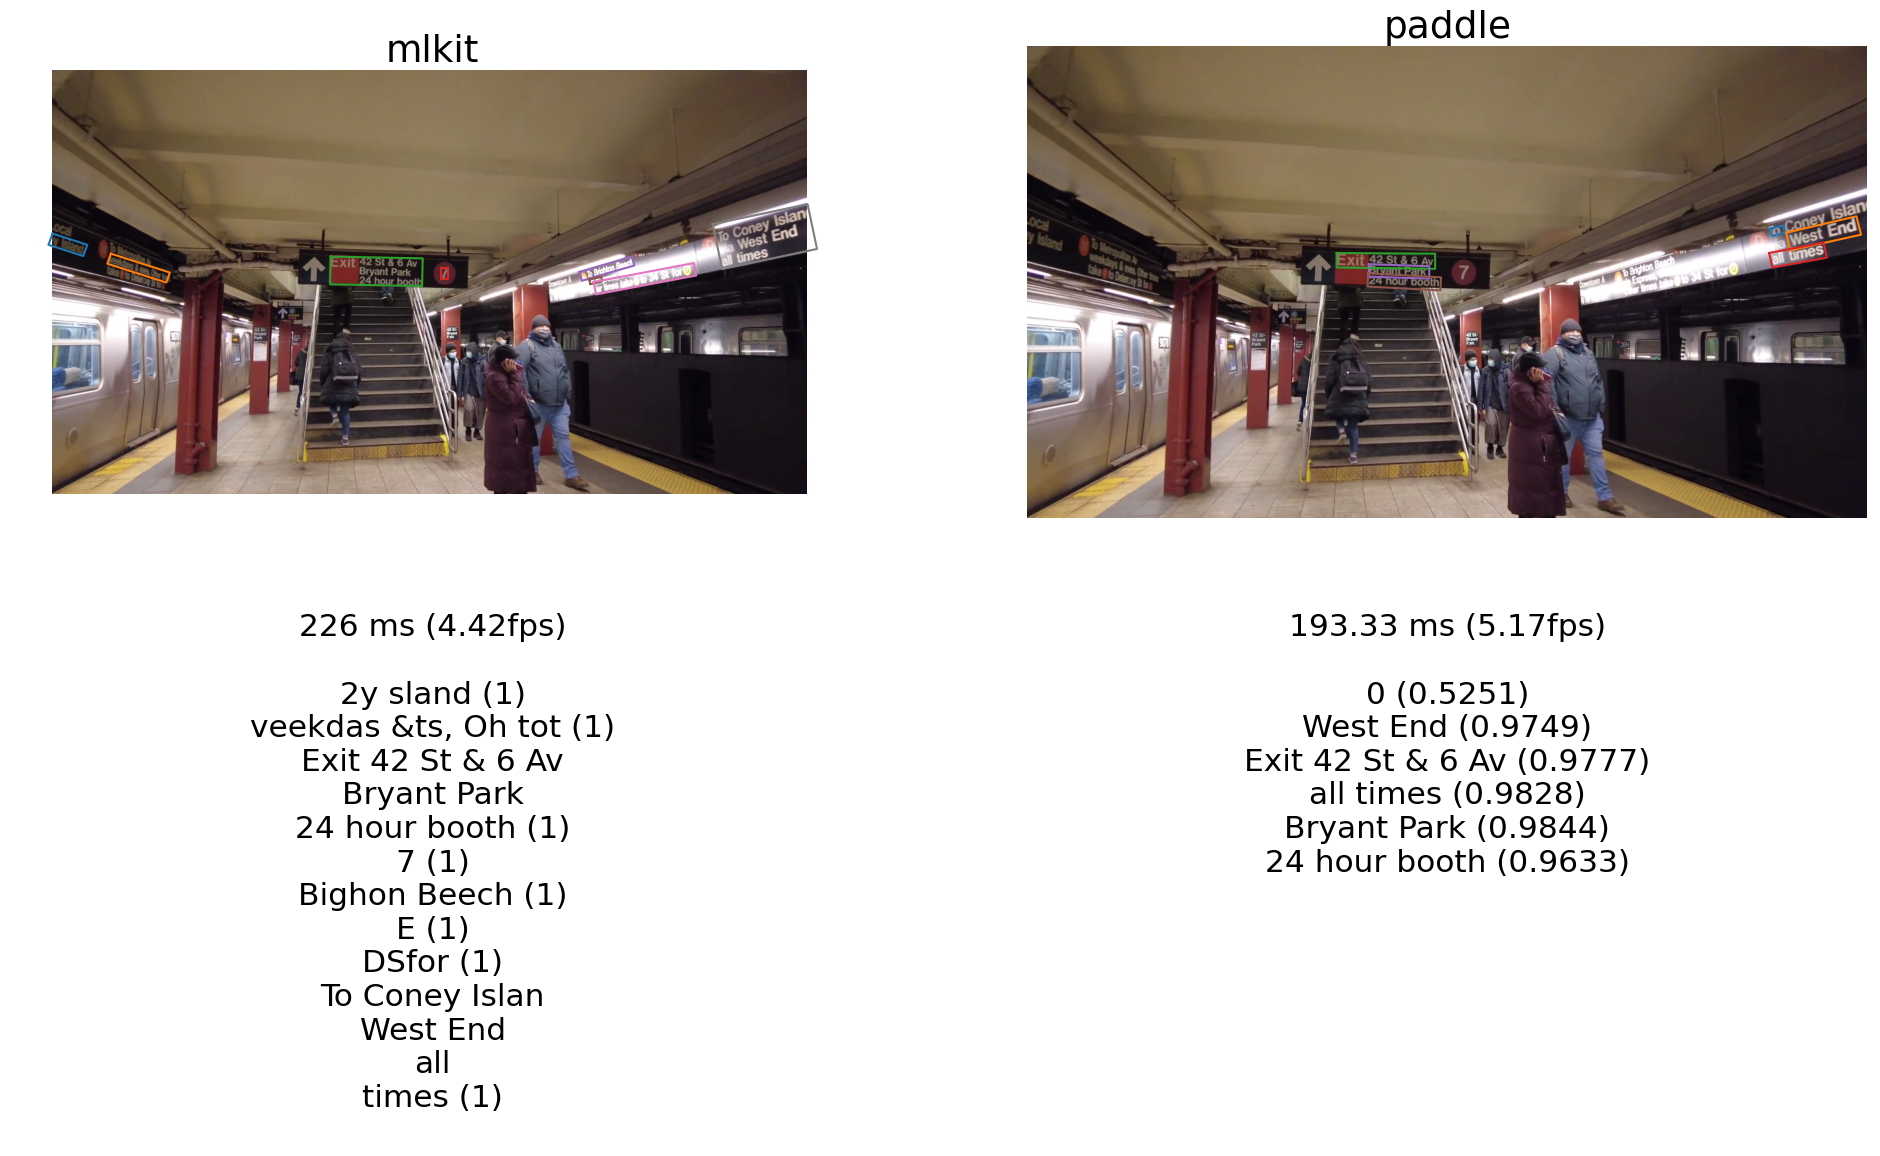

In [100]:
#Generate Image
image_select = 38 #@param {type:"integer"}
compare_0 = 'mlkit' #@param ["mlkit", "easyocr", "paddle"] {type:"string"}
compare_1 = "paddle" #@param ["mlkit", "easyocr", "paddle"] {type:"string"}

if image_select > 199 or image_select < 0:
  print('Error: Select image between 0 and 199')

json_file_0 = open(f'./ocr-testing-results/json/{compare_0}720.json')
full_data_0 = json.load(json_file_0)
data_0 = full_data_0[f'{compare_0}720'][image_select]
json_file_1 = open(f'./ocr-testing-results/json/{compare_1}720.json')
full_data_1 = json.load(json_file_1)
data_1 = full_data_1[f'{compare_1}720'][image_select]
image = cv2.imread(f'./ocr-testing-results/720/{image_select:03}.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# PLOT SCALE
plot_scale = 1.5 #@param {type:"number"}
fig = plt.figure(figsize=(16*plot_scale,9*plot_scale))
plt.rcParams.update({'font.size': 15*plot_scale})

# IMAGE 0
fig.add_subplot(2,2,1)
plt.imshow(image)
plt.axis('off')
plt.title(compare_0)

for rg in data_0['regions']:
  coord = []
  for bb in rg['bounding_box']:
    coord.append([round(bb['x']), round(bb['y'])])
  coord.append(coord[0])
  xs, ys = zip(*coord)
  plt.plot(xs,ys)

# IMAGE 1
fig.add_subplot(2,2,2)
plt.imshow(image)
plt.axis('off')
plt.title(compare_1)

for rg in data_1['regions']:
  coord = []
  for bb in rg['bounding_box']:
    coord.append([round(bb['x']), round(bb['y'])])
  coord.append(coord[0])
  xs, ys = zip(*coord)
  plt.plot(xs,ys)

# TEXT 0
fig.add_subplot(2,2,3)

time = round(data_0['time_ms'], 2)
fps = round(1/(time/1000), 2)
fulltext = data_0['plaintext']
regionText = ''
for rg in data_0['regions']:
  regionText += rg['text'] + ' (' + str(round(rg['confidence'], 4)) + ')\n'

string_0 = f'{time} ms ({fps}fps)\n\n{regionText}'

plt.text(0.5,1,string_0,ha='center',va='top')
plt.axis('off')

# TEXT 1
fig.add_subplot(2,2,4)

time = round(data_1['time_ms'], 2)
fps = round(1/(time/1000), 2)
fulltext = data_1['plaintext']
regionText = ''
for rg in data_1['regions']:
  regionText += rg['text'] + ' (' + str(round(rg['confidence'], 4)) + ')\n'

string_1 = f'{time} ms ({fps}fps)\n\n{regionText}'

plt.text(0.5,1,string_1,ha='center',va='top')
plt.axis('off')